In [29]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from os.path import join

plt.style.use(['science', 'ieee', 'no-latex'])
major, minor = 5.0, 3.0

HUE_ORDER = ["Federated", "Centralized", "Decentralized"]

In [16]:
rewards_df = pd.read_csv(join("..", "out", "experiments", "digital", "rewards.csv"))
rewards_df["trainer_intersection"].replace({
    "grid-3x3": "Grid-3x3", 
    "grid-5x5": "Grid-5x5", 
    "double": "Double"
}, inplace=True)
rewards_df["netfile"].replace({
    "grid-3x3": "Grid-3x3", 
    "grid-5x5": "Grid-5x5", 
    "double": "Double"
}, inplace=True)
rewards_df["trainer"].replace({
    "FedRL": "Federated", 
    "MARL": "Decentralized", 
    "SARL": "Centralized"
}, inplace=True)
rewards_df.head()

,Unnamed: 0,tls_id,reward,netfile,step,n_vehicles,policy,trainer,trainer_intersection,trainer_ranked,mc_run
0,0,A0,-0.0,Grid-3x3,1,1,v3_pos-reward-aggr_ranked.pkl,Federated,Double,ranked,0
1,1,A1,-0.0,Grid-3x3,1,1,v3_pos-reward-aggr_ranked.pkl,Federated,Double,ranked,0
2,2,A2,-0.0,Grid-3x3,1,1,v3_pos-reward-aggr_ranked.pkl,Federated,Double,ranked,0
3,3,B0,-0.0,Grid-3x3,1,1,v3_pos-reward-aggr_ranked.pkl,Federated,Double,ranked,0
4,4,B1,-0.0,Grid-3x3,1,1,v3_pos-reward-aggr_ranked.pkl,Federated,Double,ranked,0


In [3]:
features_df = pd.read_csv(join("..", "out", "experiments", "digital", "features.csv"))
features_df["trainer_intersection"].replace({
    "grid-3x3": "Grid-3x3", 
    "grid-5x5": "Grid-5x5", 
    "double": "Double"
}, inplace=True)
features_df["netfile"].replace({
    "grid_3x3": "Grid-3x3", 
    "grid_5x5": "Grid-5x5", 
    "double_loop": "Double"
}, inplace=True)
features_df["trainer"].replace({
    "FedRL": "Federated", 
    "MARL": "Decentralized", 
    "SARL": "Centralized"
}, inplace=True)
features_df.head()

,Unnamed: 0,feature,value,netfile,tls,policy,ranked,trainer,trainer_intersection,trainer_ranked,mc_run
0,0,lane_occupancy,0.0,grid-3x3,A0,v3_pos-reward-aggr_ranked.pkl,True,Federated,Double,ranked,0
1,1,lane_occupancy,0.0,grid-3x3,A1,v3_pos-reward-aggr_ranked.pkl,True,Federated,Double,ranked,0
2,2,lane_occupancy,0.0,grid-3x3,A2,v3_pos-reward-aggr_ranked.pkl,True,Federated,Double,ranked,0
3,3,lane_occupancy,0.0,grid-3x3,B0,v3_pos-reward-aggr_ranked.pkl,True,Federated,Double,ranked,0
4,4,lane_occupancy,0.0,grid-3x3,B1,v3_pos-reward-aggr_ranked.pkl,True,Federated,Double,ranked,0


In [17]:
matrices = {}
for trainer in rewards_df["trainer"].unique():
    for ranked in ["ranked", "unranked"]:
        matrix = []
        for trained_on in ['Grid-3x3', 'Grid-5x5', 'Double']:
            row = []
            for evaled_on in ['Grid-3x3', 'Grid-5x5', 'Double']:
                q = f"trainer == '{trainer}' and trainer_ranked == '{ranked}' and " \
                    f"trainer_intersection == '{trained_on}' and netfile == '{evaled_on}'"
                query = rewards_df.query(q)
                row.append(query["reward"].mean())
            matrix.append(row)
        matrices[trainer, ranked] = np.array(matrix)

matrices.keys()

dict_keys([('Federated', 'ranked'), ('Federated', 'unranked'), ('Decentralized', 'ranked'), ('Decentralized', 'unranked'), ('Centralized', 'ranked'), ('Centralized', 'unranked')])

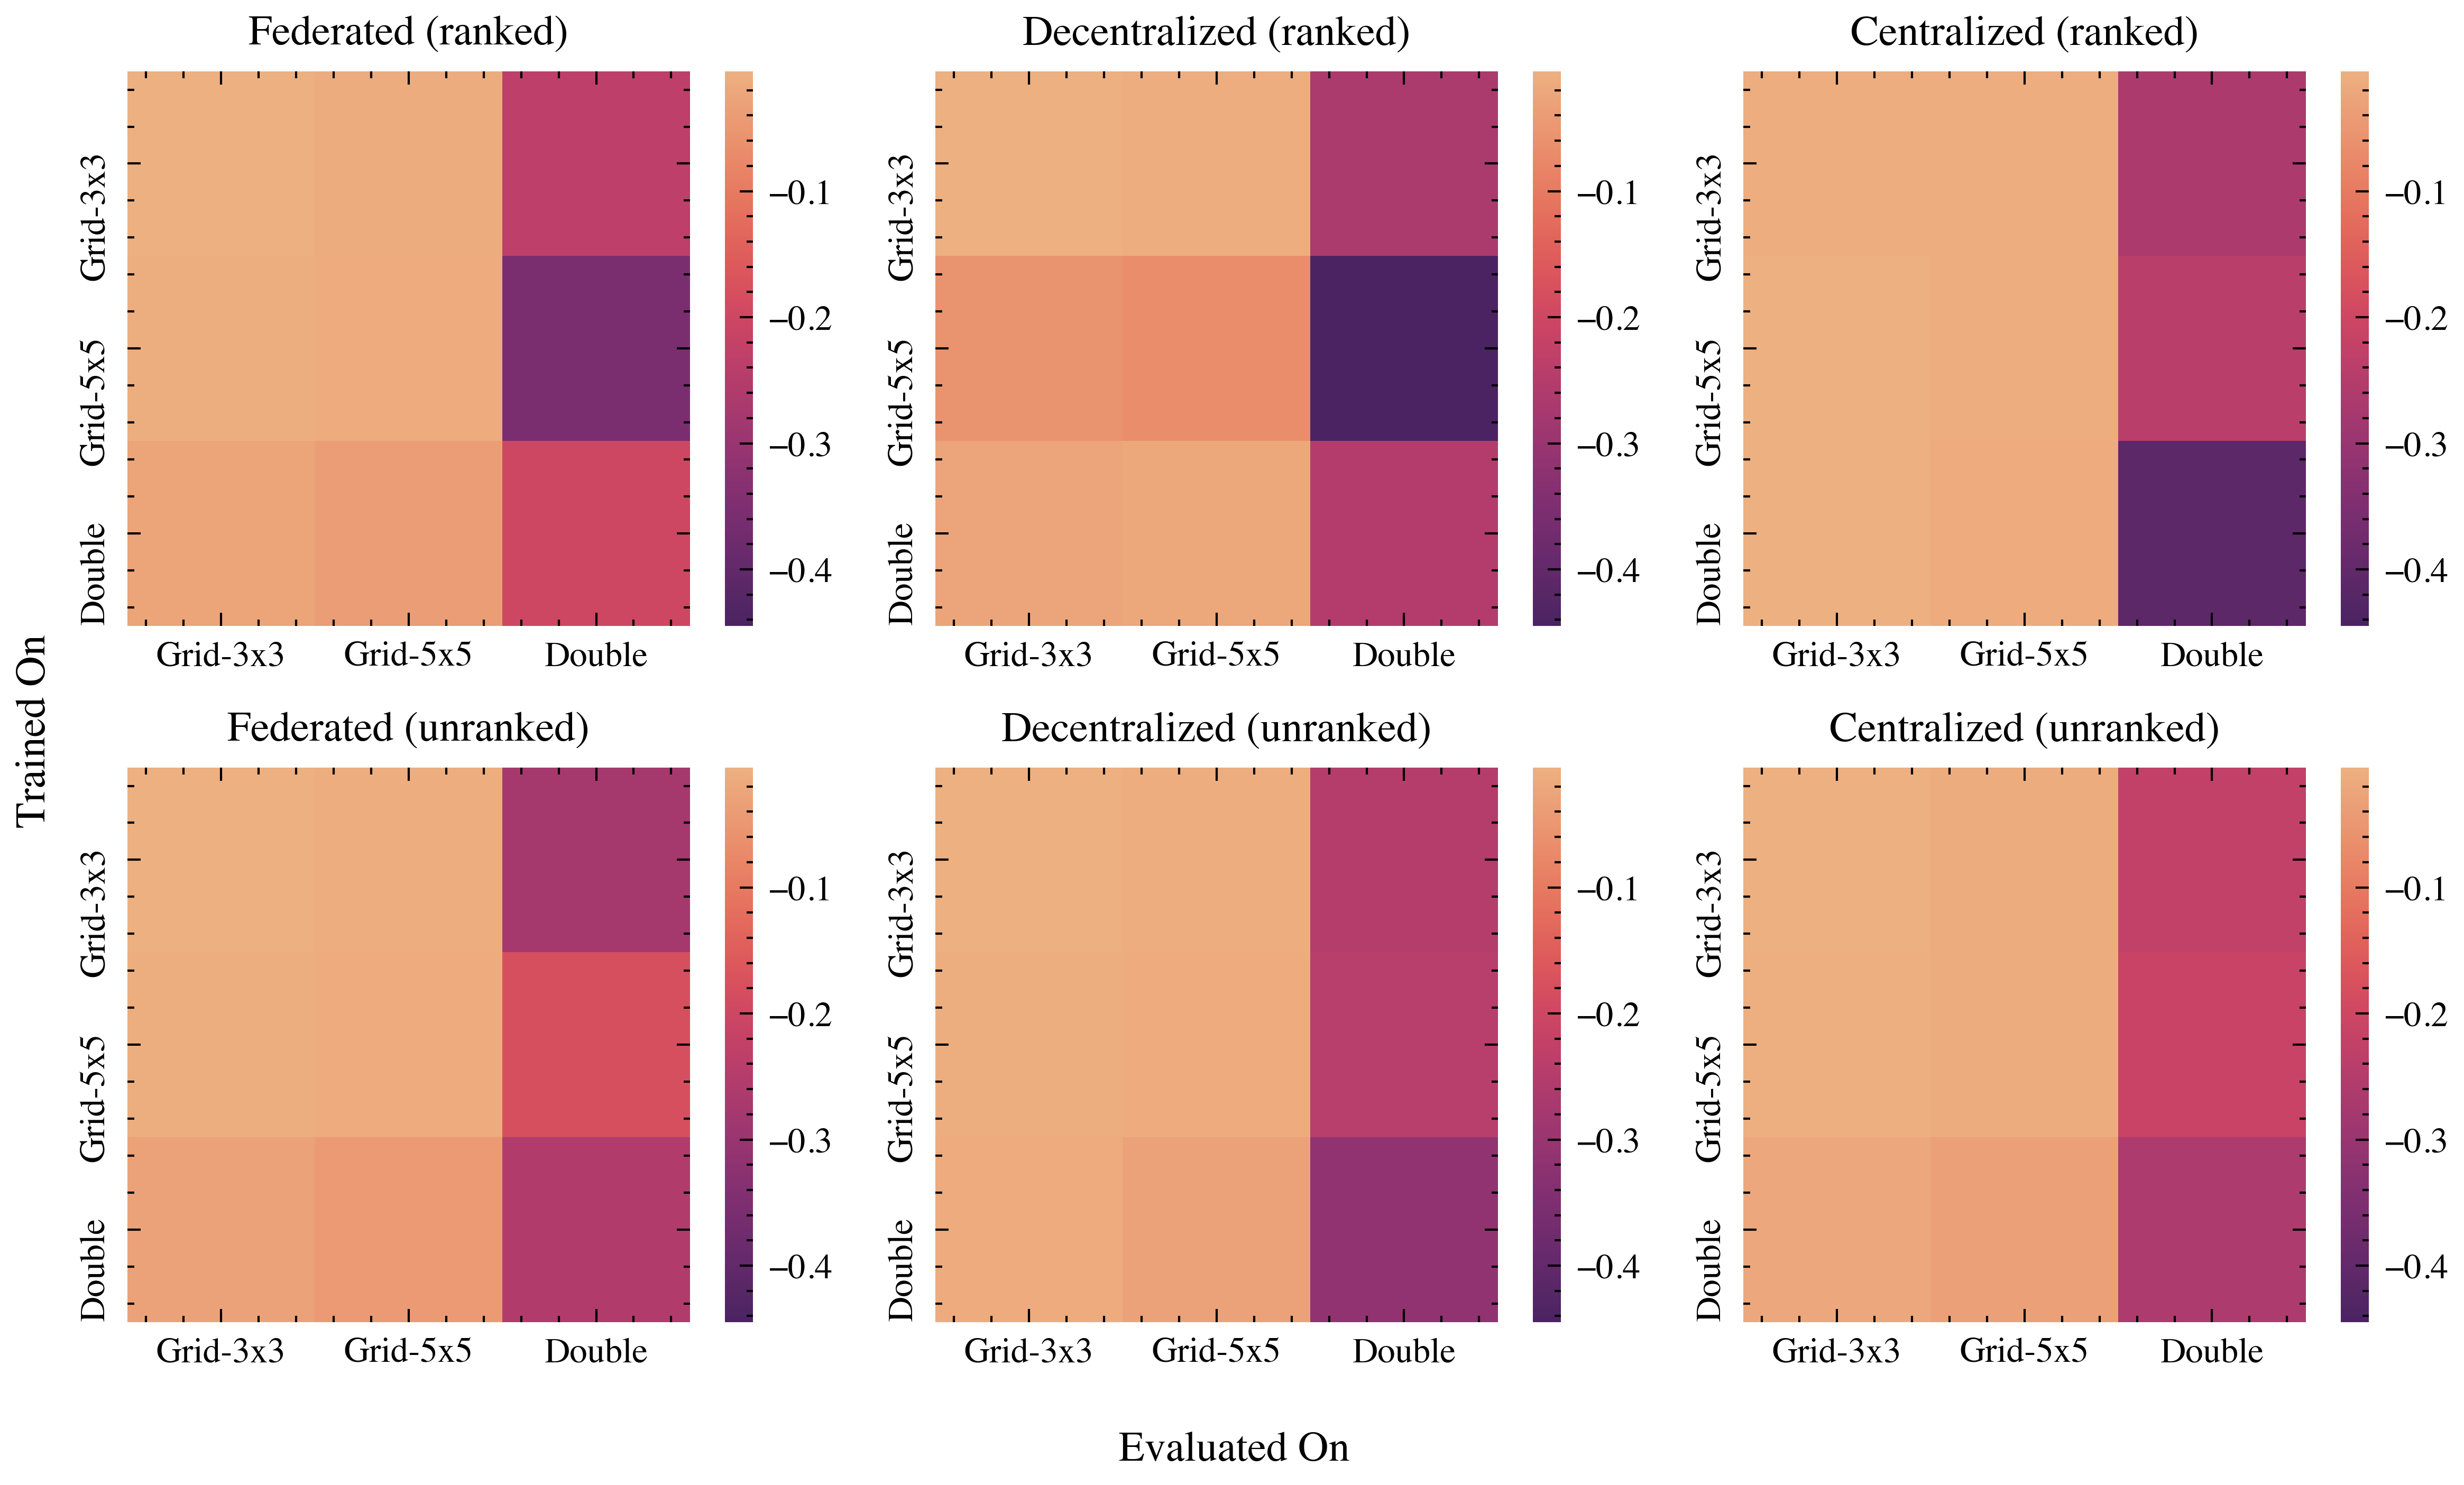

In [18]:
RANKS = ["ranked", "unranked"]
TRAINERS = ["Federated", "Decentralized", "Centralized"]

vmin, vmax = float("inf"), float("-inf")
for matrix in matrices.values():
    mat = matrix.flatten()
    vmin = min(vmin, mat.min())
    vmax = max(vmax, mat.max())
    
fig, axes = plt.subplots(nrows=len(RANKS), ncols=len(TRAINERS), figsize=(8, 4.75))

for row, ranked in enumerate(RANKS):
    for col, trainer in enumerate(TRAINERS):
        f = sns.heatmap(
            matrices[trainer, ranked],
            xticklabels=['Grid-3x3', 'Grid-5x5', 'Double'],
            yticklabels=['Grid-3x3', 'Grid-5x5', 'Double'],
            vmin=vmin,
            vmax=vmax,
            cmap="flare_r",
            ax=axes[row, col]
        )
        axes[row, col].set_title(f"{trainer} ({ranked})")

fig.supylabel("Trained On")
fig.supxlabel("Evaluated On")
plt.tight_layout()
plt.show()

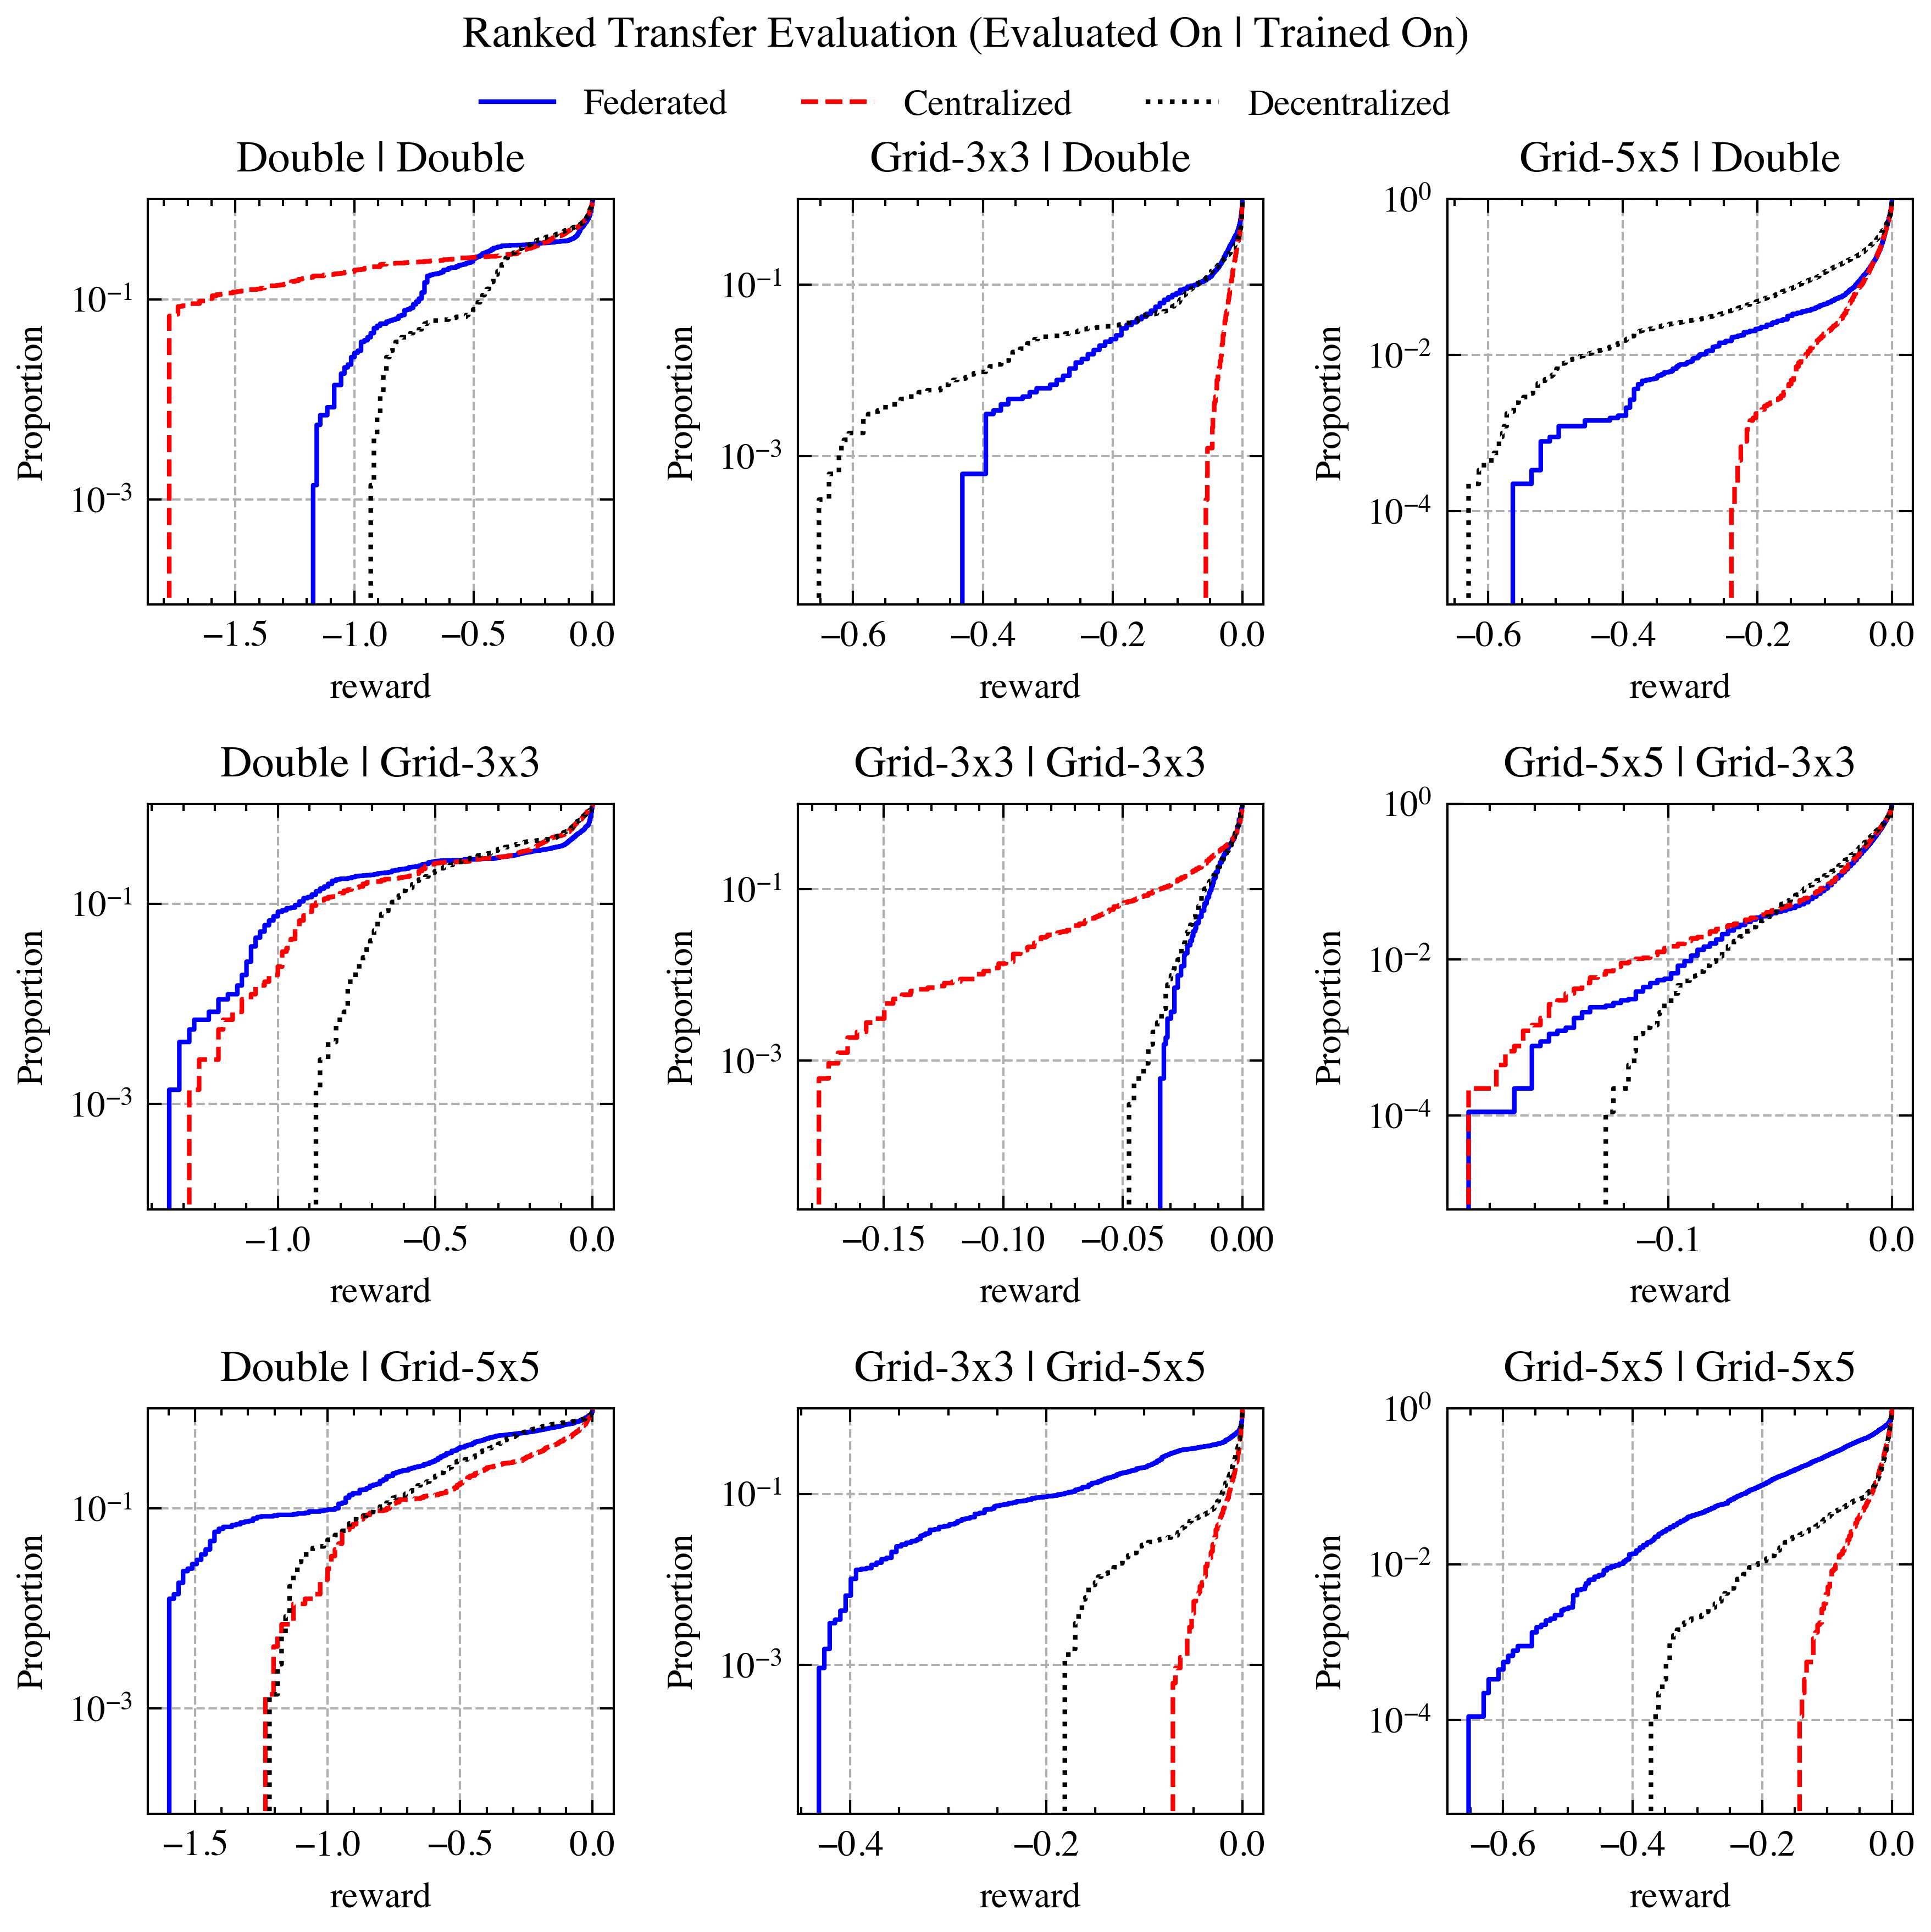

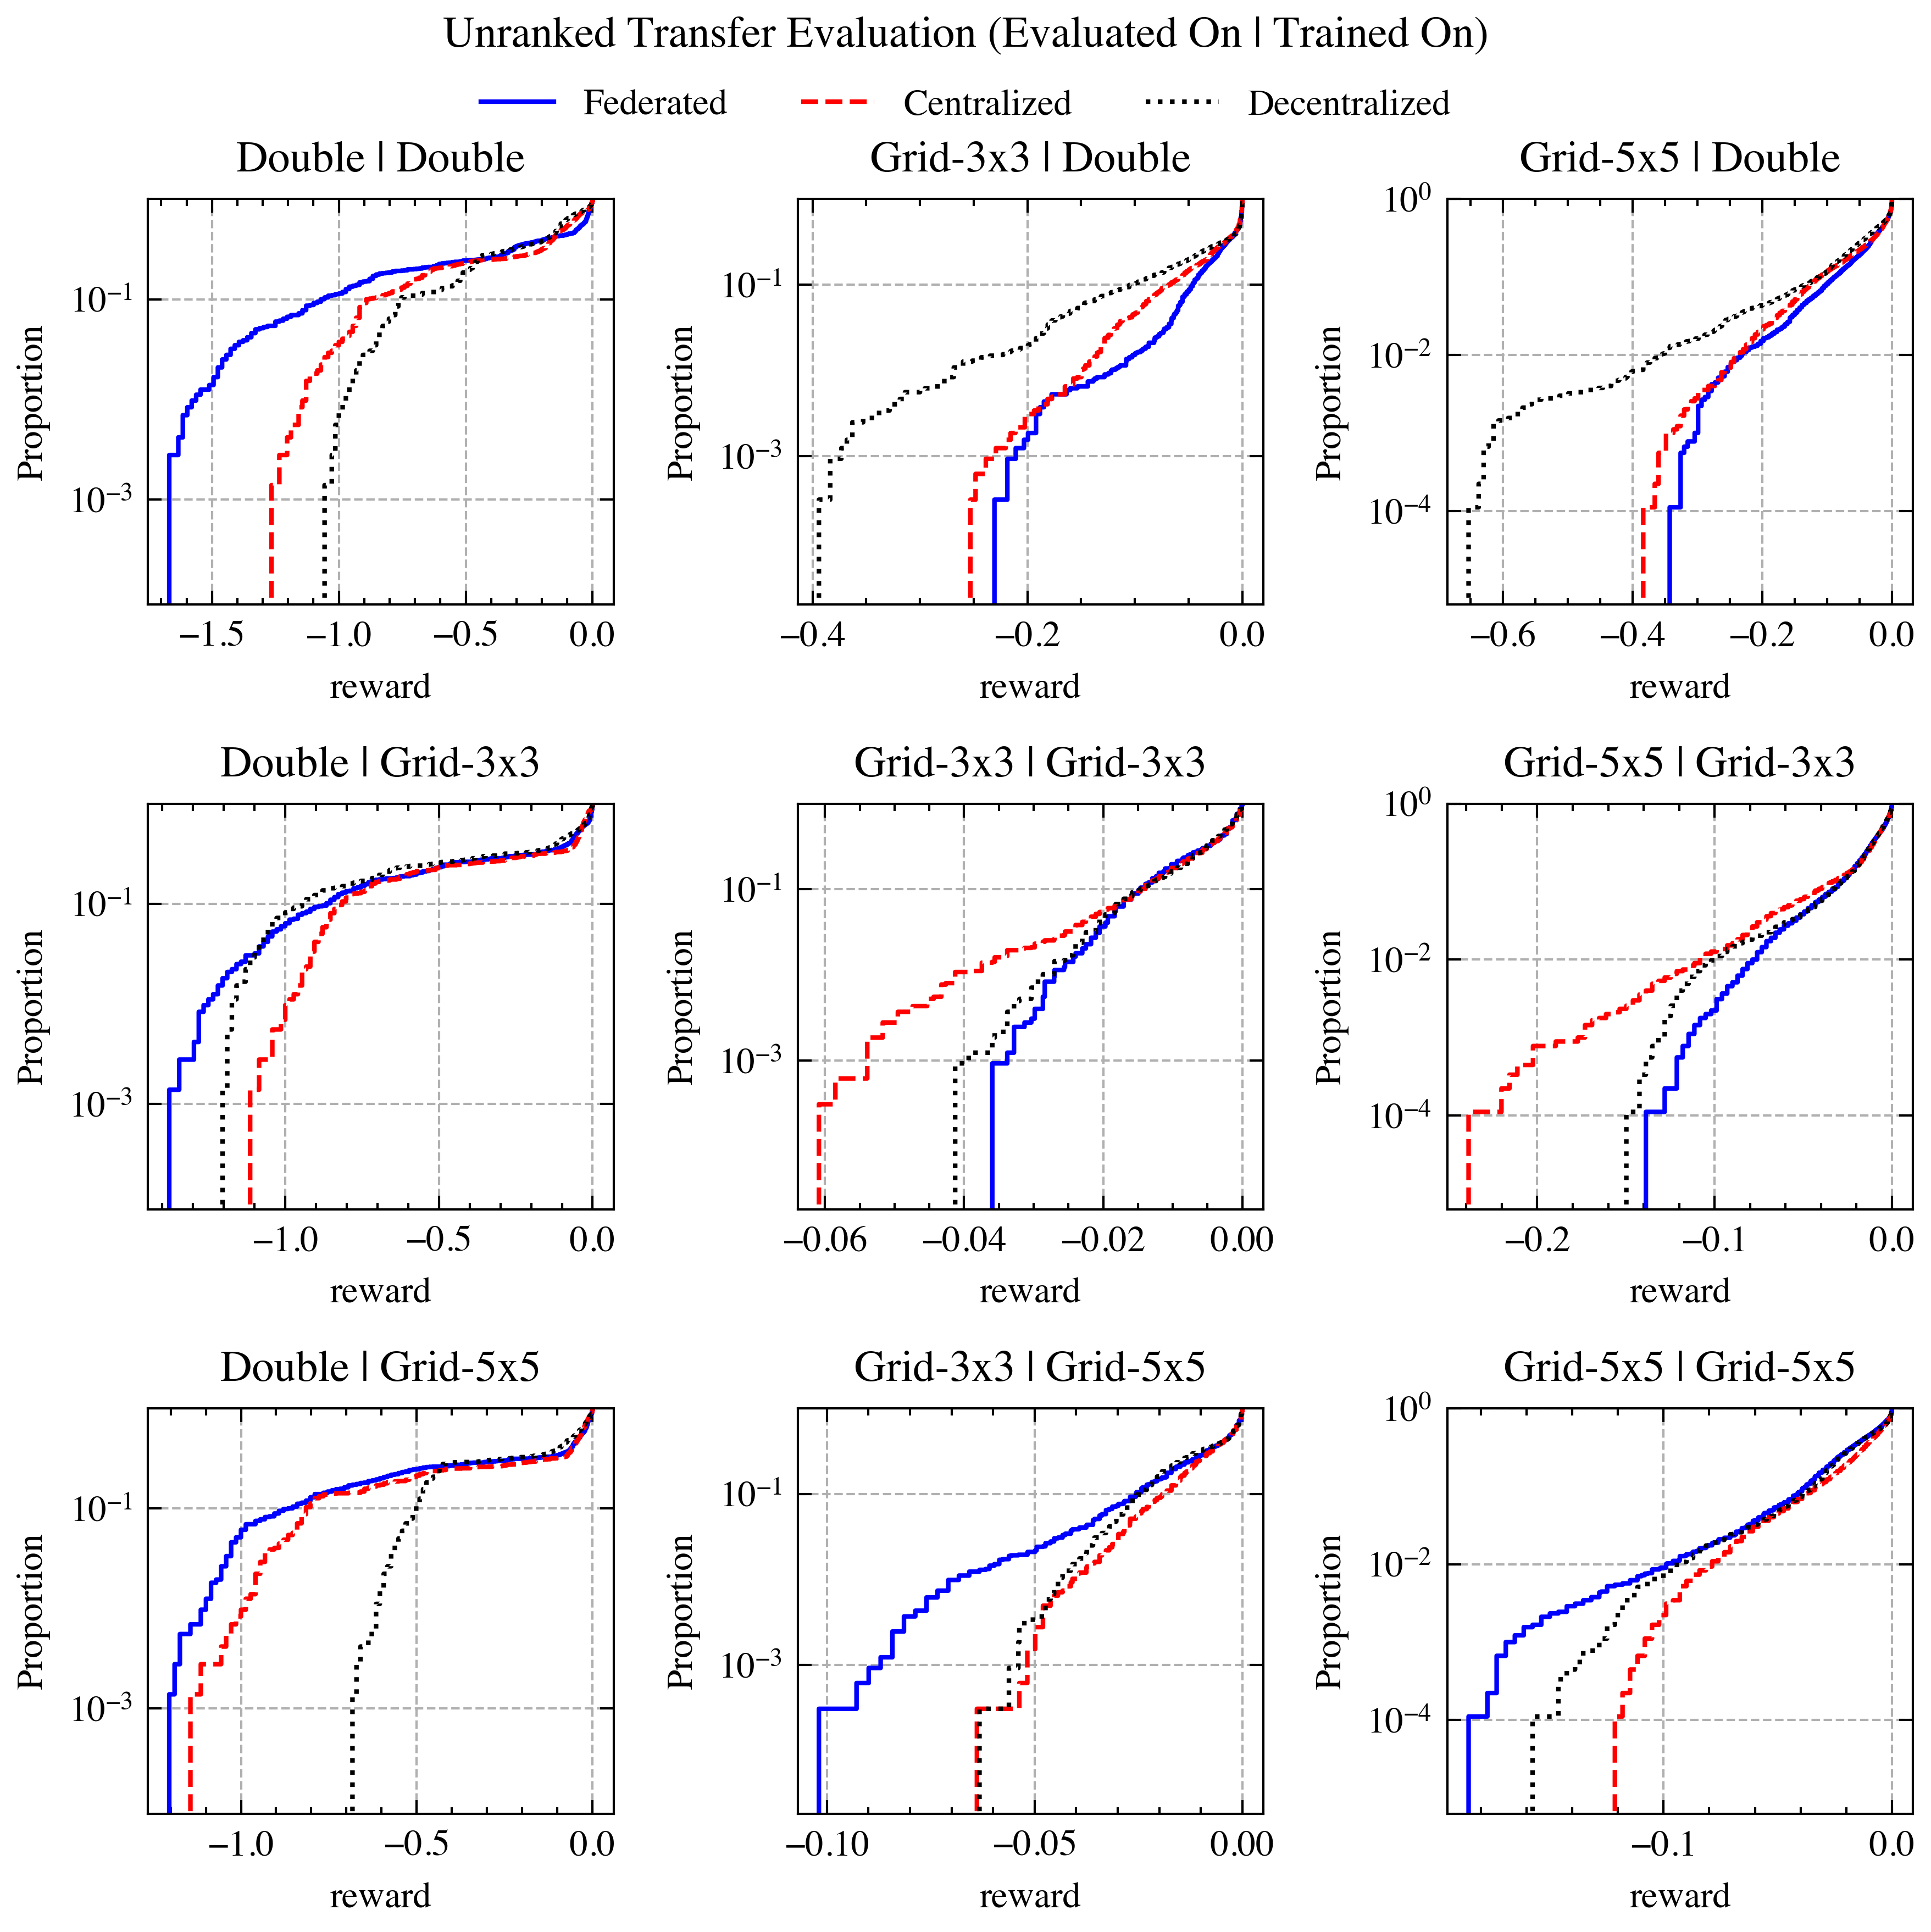

In [30]:
netfiles = ["Double", "Grid-3x3", "Grid-5x5"]

for ranked in ["ranked", "unranked"]:
    fig, ax = plt.subplots(nrows=len(netfiles), ncols=len(netfiles), figsize=(6, 6))
    for row, trained_on in enumerate(netfiles):
        for col, eval_on in enumerate(netfiles):
            q = f"trainer_intersection == '{trained_on}' and netfile == '{eval_on}' and trainer_ranked == '{ranked}'"
            sns.ecdfplot(
                data=rewards_df.query(q), 
                x="reward",
                hue="trainer", 
                hue_order=HUE_ORDER,
                ax=ax[row, col],
                # multiple="stack",
                # legend=False,
            ).set(yscale="log")
            ax[row, col].set_title(f"{eval_on} | {trained_on}")
            ax[row, col].grid(which="major", linestyle="--")
            ax[row, col].get_legend().remove()
            children = ax[row, col].get_children()

    handles = [child for child in children if isinstance(child, mpl.lines.Line2D)]
    labels = HUE_ORDER.copy()
    fig.legend(handles, labels, frameon=False, ncol=3, loc="upper center",
               bbox_to_anchor=(0.5, 0.96))  
    plt.suptitle(f"{ranked.title()} Transfer Evaluation (Evaluated On | Trained On)\n")
    plt.tight_layout()
    plt.show()

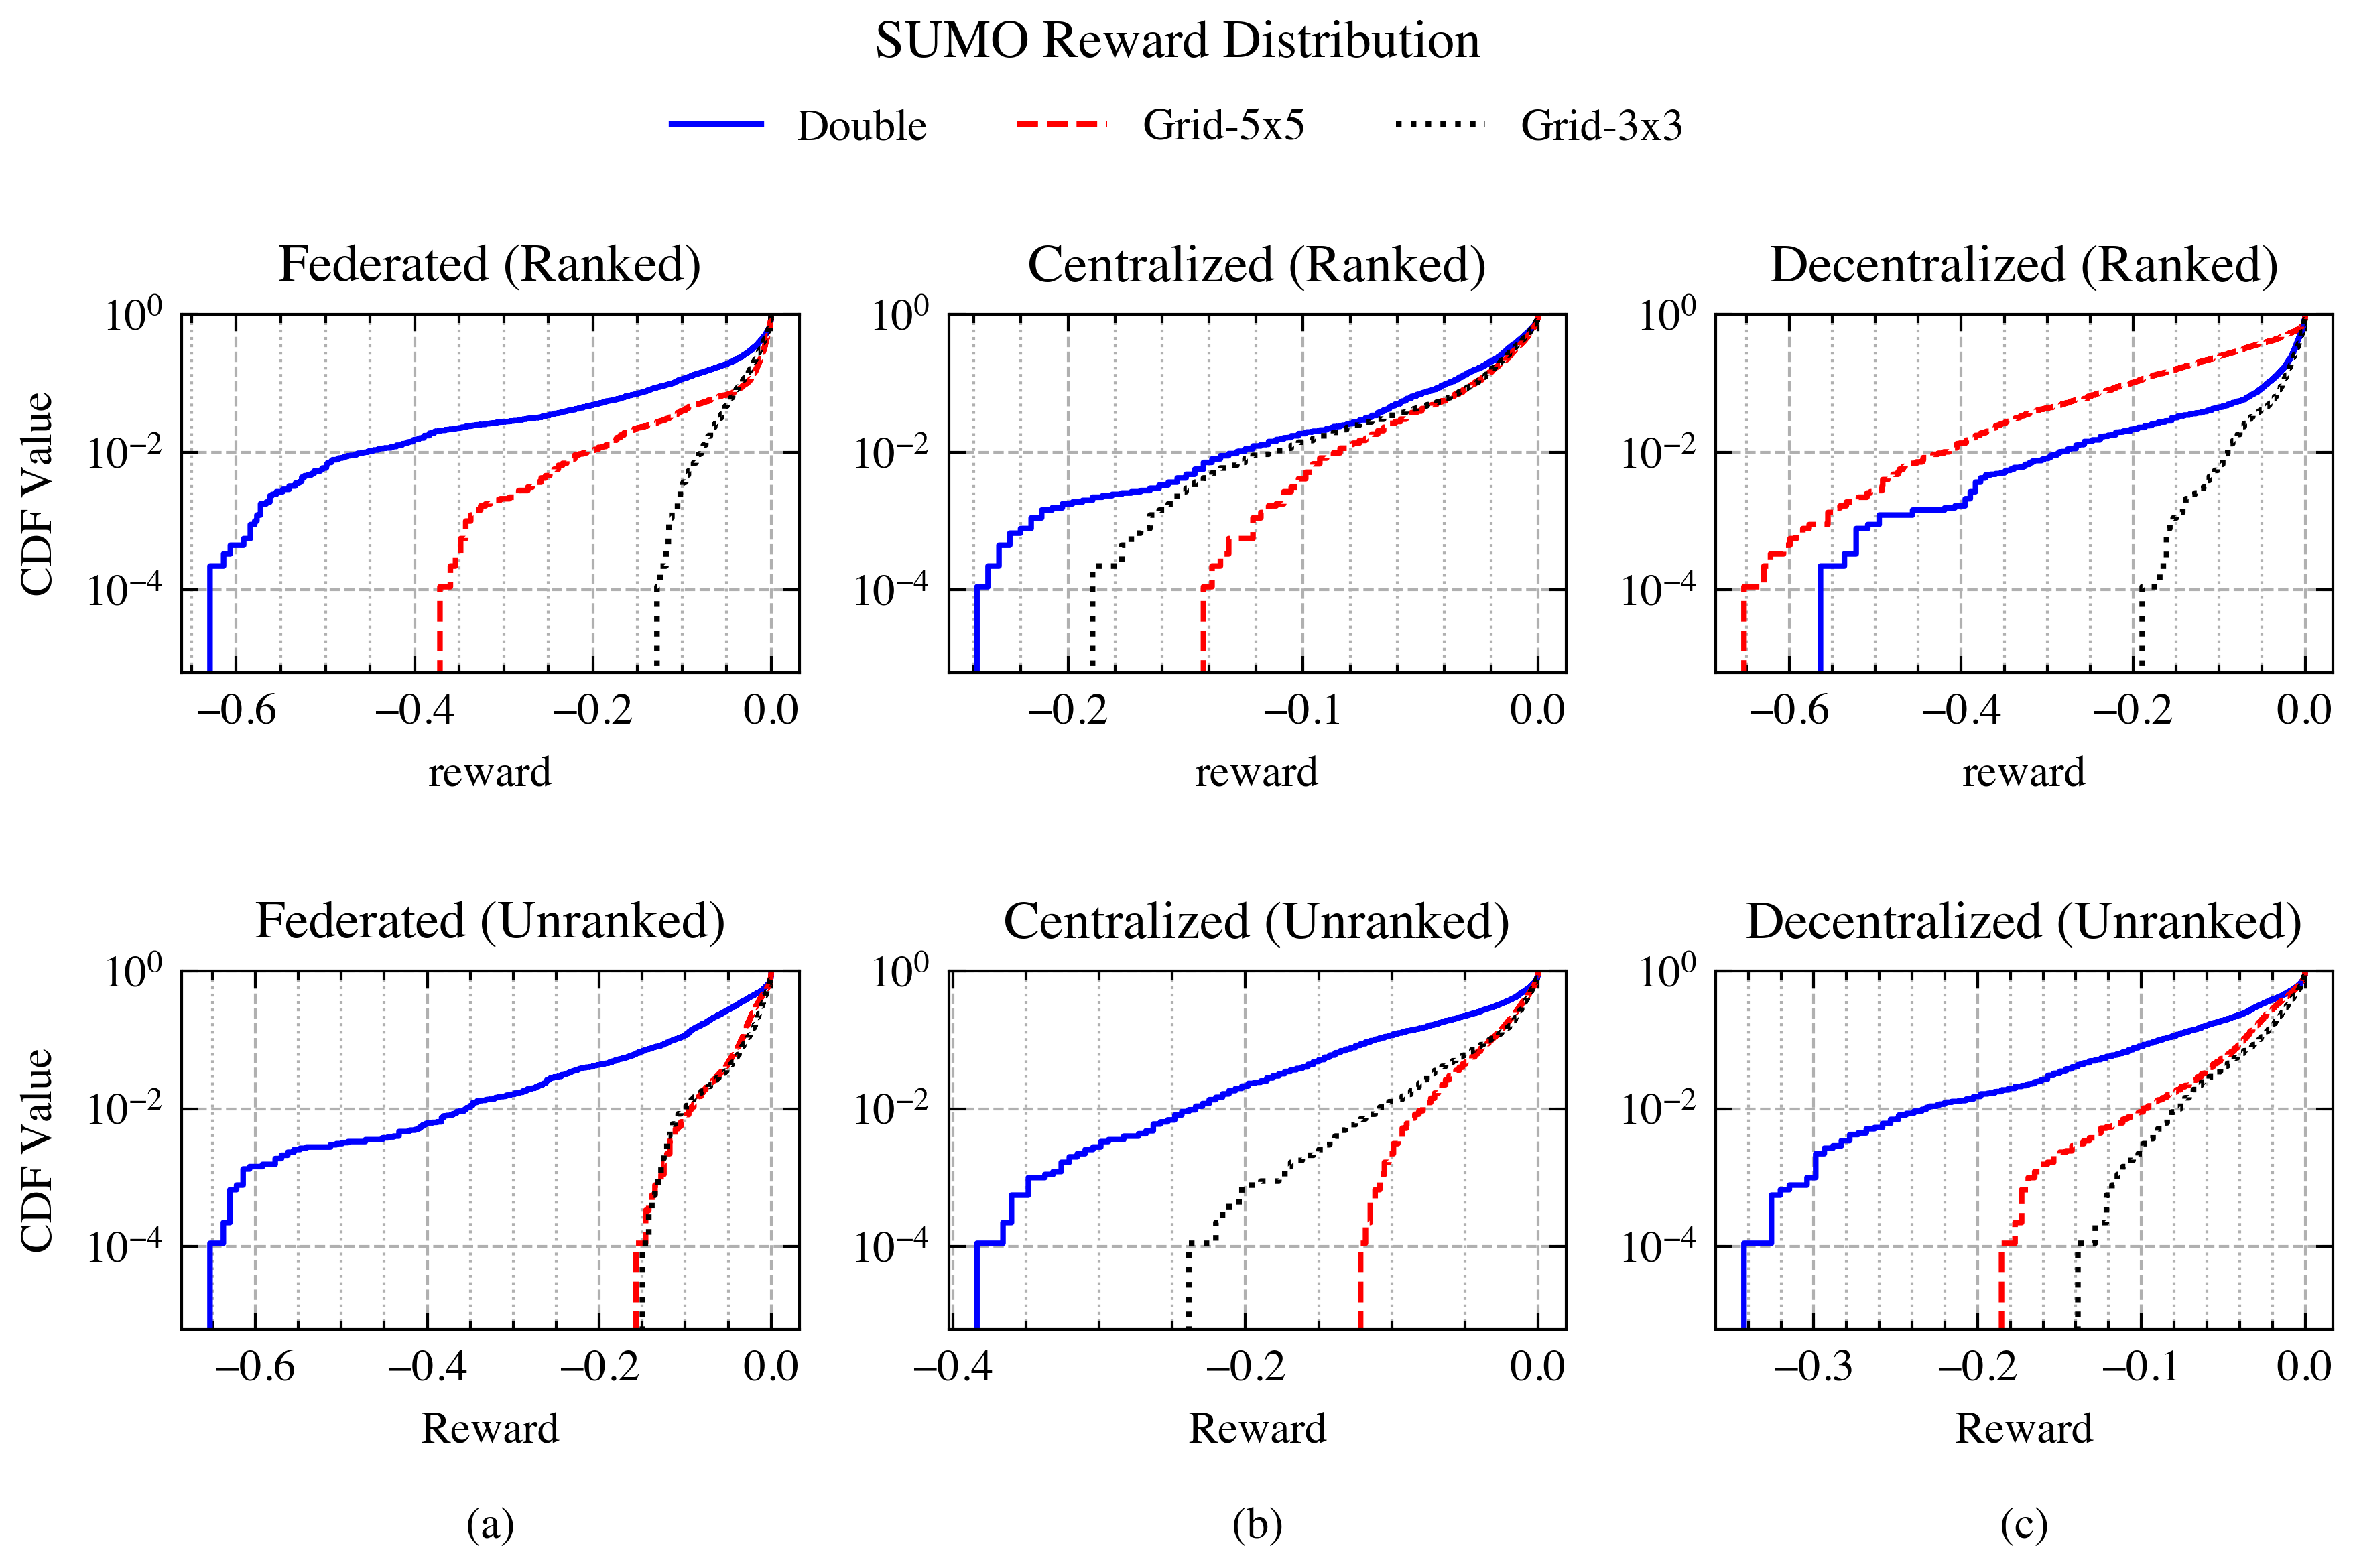

In [40]:
with sns.plotting_context(font_scale=1.15):
    NROWS, NCOLS = 2, 3
    fig, axes = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(6, 4))
    for (row, ranked) in enumerate(['ranked', 'unranked']):
        for (col, trainer) in enumerate(["Federated", "Centralized", "Decentralized"]):
            q = f"trainer == '{trainer}' and trainer_ranked == '{ranked}' and netfile == 'Grid-5x5'"
            sns.ecdfplot(
                data=rewards_df.query(q),
                x="reward",
                hue="trainer_intersection",
                hue_order = ["Grid-3x3", "Grid-5x5", "Double"],
                ax=axes[row, col]
            ).set(yscale="log")

            axes[row, col].grid(which="major", linestyle="--")
            axes[row, col].grid(which="minor", linestyle=":")
            axes[row, col].set_title(f"\n{trainer} ({ranked.title()})")
            handles, labels = axes[row, col].get_legend_handles_labels()
            axes[row, col].get_legend().remove()
            children = axes[row, col].get_children()

    for row in range(NROWS):
        for col in range(1, NCOLS):
            axes[row, col].set_ylabel("")

    for label, col in zip(["a", "b", "c"], range(NCOLS)):
        axes[1, col].set_xlabel(f"Reward\n\n({label})")

    for row in range(NROWS):
        axes[row, 0].set_ylabel("CDF Value")

    handles = [child for child in children if isinstance(child, mpl.lines.Line2D)]
    labels = ["Double", "Grid-5x5", "Grid-3x3"]
    fig.legend(handles, labels, frameon=False, ncol=3, loc="upper center",
               bbox_to_anchor=(0.5, 0.95))
    fig.suptitle("SUMO Reward Distribution\n")
    plt.tight_layout()
    # plt.savefig(join(RESULTS_DIR, "real-world_reward_ecdf.pdf"))
    plt.show()